# HD135344 B - ALMA

*Author: Valentin Christiaens*

# Table of contents

* [1. Importations and definitions](#1.-Importations-and-definitions)
    - [1.1. Importations](#1.1.-Importations)
    - [1.2. Definition of parameters](#1.2.-Definition-of-parameters)
* [2. Image preparation](#2.-Image-preparation)
* [3. Denoise](#3.-Denoise)
* [4. Deprojection](#4.-Deprojection)
* [5. Spiral tracing and fitting](#5.-Spiral-tracing-and-fitting)
    - [5.1. S1](#5.1.-S1)
    - [5.2. S2](#5.2.-S2)
* [6. Plot all fits](#6.-Plot-all-fits)   

Details on both the procedure and the dataset used in this example can be found in [Casassus, Christiaens et al. (2021)](https://ui.adsabs.harvard.edu/abs/2021MNRAS.507.3789C/abstract).

## 1. Importations and definitions

### 1.1. Importations

In [1]:
#from hciplot import hciplot as hp
import diskmap
import glob
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
import os
from os import listdir
from os.path import isfile, isdir, join
import scipy

import vip_hci as vip
from vip_hci.fits import open_fits, write_fits
from vip_hci.preproc import frame_crop, frame_shift
from vip_hci.var import frame_center, frame_filter_lowpass
import hciplot as hp

### 1.2. Definition of parameters

Let's define important parameters for the reduction:

In [2]:
# PATHS
source = 'HD135344B'
cdir = os.getcwd()
path = 'ExampleFiles/'
inpath = path+'input/'
outpath = path+'fits/'
outpath_fig = path+'figures/'
if not os.path.exists(outpath):
    os.system('mkdir '+outpath)
if not os.path.exists(outpath_fig):
    os.system('mkdir '+outpath_fig)

IRDIS_imgname = "HD135344B_2016-06-30_Q_phi_star_pol_subtr"

# PLOT PARAMS
font = {'style' : 'normal',
        'family':'serif',
        'serif':"Times",
        'size'   : 12}
matplotlib.rc('font', **font)
ft_sz_tit = 20      # Title font size
ft_sz_ax = 16       # Axis font size
plt.rcParams['pdf.fonttype'] = 42

In [3]:
# Disc parameters. Check literature. 
incl = -16.    # Disc inclination. Only used for disc deprojection
PA = 61.9      # Disc PA of semi-major axis. Convention for diskmap: counter-clockwise from PA should be far side of the disc.
dist = 135.7 # distance in pc

In [4]:
# Global params for spiral tracing and deprojection (params for individual spirals set before each relevant cell)
## spiral params
search_mode = 'minimize' # how is the best fit found? Choice between {'minimize','linsearch'}. minimize=simplex; linsearch=grid search.
clockwise = True         # whether the spirals are clockwise or counter-clockwise
## Plot options
plot_format_paper = True # whether format of figures should be paper-ready
log_plot = False         # log scale or not? 
cbar_label = 'Tb (K)'    # Label for color bar
y_ax_lab= 'd'            # label for x axis
x_ax_lab= y_ax_lab       # label for y axis
scale_au = 20            # au (size of the scale shown in the image)
scale_as = 0.2           # arcsec (size of the scale shown in the image)
ang_offset = 90          # offset between trigonometric and PA angle

In [5]:
## preproc
crop_as = 1.5 # crop size in arcsec

In [6]:
# IRDIS information
plsc_ird = 0.01226      # arcsec/px
fwhm_ird=0.039/plsc_ird # cf. Stolker et al. 2017
print(fwhm_ird)

3.1810766721044046


# 2. Image preparation

Load and crop to odd-dimensions while preserving center:

In [7]:
tmp = open_fits(inpath+IRDIS_imgname)
if not tmp.shape[-1]%2:
    tmp = frame_shift(tmp,0.5,0.5)
    tmp=tmp[1:,1:]

Fits HDU-0 data successfully loaded. Data shape: (121, 121)


Crop to requested size - if necessary:

In [8]:
crop_sz_ird = int(crop_as/plsc_ird)
if not crop_sz_ird%2:
    crop_sz_ird-=1
if crop_sz_ird < tmp.shape[-1]:
    true_ori_img_ird = frame_crop(tmp, crop_sz_ird)
    tmp=true_ori_img_ird.copy()

Set plot options:

In [9]:
tick_sep_as = 0.2
cmap = 'gist_heat'
colorbar=True

Save original image in pdf format:

In [10]:
hp.plot_frames(tmp, 
               vmax=float(np.percentile(tmp,99.99)), 
               vmin=max(float(np.percentile(tmp,0.01)),1e-2), 
               lab_fontsize=10, #label_pad=(5,int(0.8*dim_fig)),
               log=True,
               title = '', label='', ang_scale=True, # $-$ 2014/05/09
               ang_ticksep=tick_sep_as/plsc_ird, pxscale=plsc_ird, ang_legend=False, 
               axis=True, ndec=1,
               show_center=True, cmap=cmap, colorbar=colorbar, #colorbar_ticks=tuple(np.linspace(np.amin(frame1)))
               dpi=300, save=outpath_fig+'IRDIS_ori.pdf')#, width=dim_fig, height=dim_fig)#, save=outpath+"FigApp1{}{}_mask{:.1f}.pdf".format(idx[ii],version,mask_as))

`Pixel scale set to 0.01226`


/Users/Valentin/GitHub/hciplot/hciplot/hciplot.py:434: MatplotlibDeprecationWarning: default base will change from np.e to 10 in 3.4.  To suppress this warning specify the base keyword argument.
  norm = colors.SymLogNorm(linthresh)
/Users/Valentin/GitHub/hciplot/hciplot/hciplot.py:452: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  vmax=vmax[i])


In [11]:
write_fits(outpath+IRDIS_imgname+"_crop.fits", tmp)

Fits file successfully overwritten


# 3. Denoise

**Only if needed!**

Set `denoise` to False if input images are of good quality.

In [12]:
denoise = True

If input image is of poor quality, run the cells below for a few values of denoise beam size at max intensity, and pick the best trade-off between smoothness of trace and loss in resolution.


In [13]:
if denoise:
    denoise_beam_sz = 1. # px
    os.system("rm "+outpath+IRDIS_imgname+"_crop_denoise.fits")
    print("denoise --beam={:.0f} ".format(denoise_beam_sz)+outpath+IRDIS_imgname+"_crop.fits")
    os.system("denoise --beam={:.0f} ".format(denoise_beam_sz)+outpath+IRDIS_imgname+"_crop.fits")  
    tmp = open_fits(outpath+IRDIS_imgname+"_crop_denoise.fits")[0]

denoise --beam=1 ExampleFiles/fits/HD135344B_2016-06-30_Q_phi_star_pol_subtr_crop.fits
Fits HDU-0 data successfully loaded. Data shape: (1, 121, 121)


In [14]:
if denoise:
    hp.plot_frames(tmp, vmax=float(np.percentile(tmp,99.)), 
                   vmin=max(float(np.percentile(tmp,0.1)),2e-5), 
                   lab_fontsize=10, #label_pad=(5,int(0.8*dim_fig)),
                   log=True,
                   title = '', label='', ang_scale=True, # $-$ 2014/05/09
                   ang_ticksep=tick_sep_as/plsc_ird, pxscale=plsc_ird, ang_legend=False, 
                   axis=True, ndec=1,
                   show_center=True, cmap=cmap, colorbar=colorbar, #colorbar_ticks=tuple(np.linspace(np.amin(frame1)))
                   dpi=300, save=outpath+IRDIS_imgname+'_denoise.pdf')#, width=dim_fig, height=dim_fig)#, save=outpath+"FigApp1{}{}_mask{:.1f}.pdf".format(idx[ii],version,mask_as))

`Pixel scale set to 0.01226`


# 4. Deprojection

**Only if needed!**

Set `deproject` to False if input image does not require deprojection of the disc.

In [15]:
deproject = True
if not deproject:
    incl = 0
    PA=0

In [16]:
# first define the routine to convert from cartesian to polar - necessary to find radial maxima
from skimage.transform import warp
def polar2cart_warp(coords,center):
    theta = coords[:,0]*360./np.max(coords[:,0])
    rr = coords[:,1]
    cen_y, cen_x = center[0],center[1]
    x = rr * np.cos(np.deg2rad(theta)) + cen_x
    y = rr * np.sin(np.deg2rad(theta)) + cen_y
    # Now we write the new coords in the same array
    coords[:,0] = x
    coords[:,1] = y
    return coords

In [17]:
# reload if the external module is modified
import trace_and_fit_one_spiral
from trace_and_fit_one_spiral import fit_one_spiral_arm
import spiral_fit

In [18]:
pi = np.pi

#### r2-scaling

In [19]:
mapping = diskmap.DiskMap(fitsfile=outpath+IRDIS_imgname+"_crop.fits",
                          pixscale=plsc_ird,
                          inclination=incl,
                          pos_angle=PA,
                          distance=dist,
                          image_type='polarized')

In [20]:
# disk parametrisation from Stolker et al. 2016
h0 = 0.015 # 0.1 in Muto et al. 2012, 0.07 in Stolker et al. 2016 for density. H-band scattering surface at 0.015?
r0 = 30    # au 53 au (planet of S1) in Muto et al. 2012; 30 in Stolker et al. 2016
psi= 0.207 # 0.207  # 0.25 in Stolker et al. 2016 for density. Measured 0.207 in Avenhaus et al. for H-band scattering surface. 
c = h0*r0**-psi
print(c)
print(c*(34.2*plsc_ird*dist)**psi)

0.007418688897366463
0.01712506068209915


In [21]:
mapping.map_disk(power_law=(0., c, psi),
                 radius=(0.01, 1500., 100))

In [22]:
mapping.write_output(filename=outpath+'HD135344B_IRDIS')

In [23]:
mapping.r2_scaling(r_max=100.)
mapping.write_output(filename=outpath+'HD135344B_IRDIS')

In [24]:
# deprojection with NO r2-scaling
mapping.deproject_disk()
mapping.write_output(filename=outpath+'HD135344B_IRDIS')

In [25]:
glob.glob(outpath+'*.fits')

['ExampleFiles/fits/HD135344B_IRDIS_r2_scaled_deprojected.fits',
 'ExampleFiles/fits/HD135344B_IRDIS_radius.fits',
 'ExampleFiles/fits/HD135344B_2016-06-30_Q_phi_star_pol_subtr_crop_denoise.fits',
 'ExampleFiles/fits/HD135344B_IRDIS_r2_scaled.fits',
 'ExampleFiles/fits/HD135344B_IRDIS_scat_angle.fits',
 'ExampleFiles/fits/HD135344B_2016-06-30_Q_phi_star_pol_subtr_crop.fits',
 'ExampleFiles/fits/HD135344B_IRDIS_r2_scaled_radius.fits',
 'ExampleFiles/fits/HD135344B_IRDIS_deprojected.fits',
 'ExampleFiles/fits/HD135344B_IRDIS_r2_scaled_scat_angle.fits']

#### Deprojection of r2-scaled image

In [26]:
r2_mapping = diskmap.DiskMap(fitsfile=outpath+"HD135344B_IRDIS_r2_scaled.fits",
                              pixscale=plsc_ird,
                              inclination=incl,
                              pos_angle=PA,
                              distance=dist,
                              image_type='polarized')

In [27]:
r2_mapping.map_disk(power_law=(0., c, psi),
                    radius=(0.01, 1500., 100))

In [28]:
# deprojection with NO r2-scaling
r2_mapping.deproject_disk()
r2_mapping.write_output(filename=outpath+'HD135344B_IRDIS_r2_scaled')

In [29]:
glob.glob(outpath+'HD135344B_IRDIS_r2_scaled*.fits')

['ExampleFiles/fits/HD135344B_IRDIS_r2_scaled_deprojected.fits',
 'ExampleFiles/fits/HD135344B_IRDIS_r2_scaled.fits',
 'ExampleFiles/fits/HD135344B_IRDIS_r2_scaled_radius.fits',
 'ExampleFiles/fits/HD135344B_IRDIS_r2_scaled_scat_angle.fits']

In [30]:
deproj_rad = open_fits(outpath+"HD135344B_IRDIS_radius.fits")
r2_img = open_fits(outpath+'HD135344B_IRDIS_r2_scaled.fits')
r2_img = frame_filter_lowpass(r2_img, fwhm_size=fwhm_ird/2)
deproj_img = open_fits(outpath+'HD135344B_IRDIS_deprojected.fits')
deproj_img[np.where(np.isnan(deproj_img))] = 0
r2_deproj_img = open_fits(outpath+'HD135344B_IRDIS_r2_scaled_deprojected.fits')
r2_deproj_img = frame_filter_lowpass(r2_deproj_img, fwhm_size=fwhm_ird/2)
r2_deproj_img[np.where(np.isnan(r2_deproj_img))] = 0

Fits HDU-0 data successfully loaded. Data shape: (121, 121)
Fits HDU-0 data successfully loaded. Data shape: (121, 121)
Fits HDU-0 data successfully loaded. Data shape: (121, 121)
Fits HDU-0 data successfully loaded. Data shape: (121, 121)


Let's compare the different images so far:

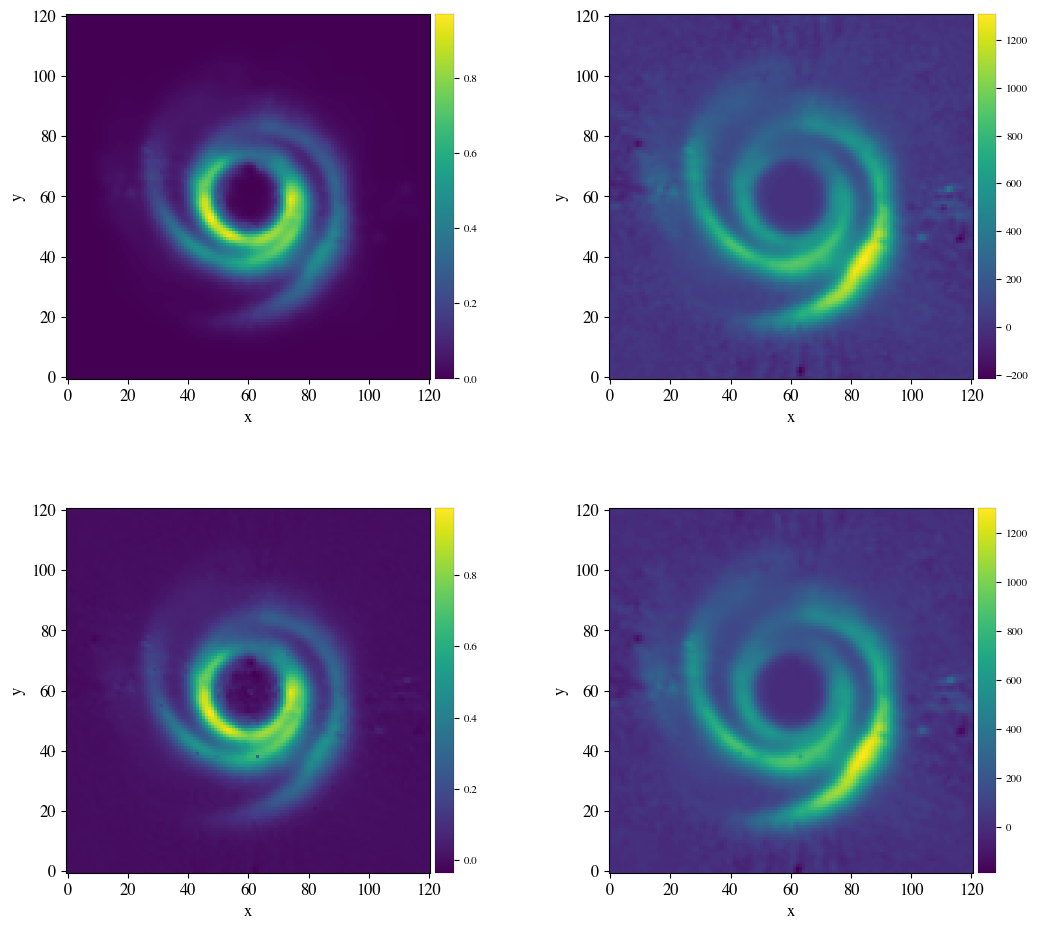

In [31]:
hp.plot_frames((tmp, r2_img, deproj_img, r2_deproj_img), rows=2)

There are 2 conspicuous spiral arms. Let's label the right one S1, and the left one S2. Let's characterize them.

# 5. Spiral tracing and fitting

### Use deprojected/r2-scaled/filtered or not?

In [32]:
deproj = True
r2 = True
filtered = True # whether to low-pass filter image to avoid picking up noise as local radial maxima

In [33]:
tmp_filt = open_fits(outpath+IRDIS_imgname+"_crop.fits")
if filtered:
    # Filter input image for easier identification of local radial maxima
    tmp_filt = frame_filter_lowpass(tmp, fwhm_size=fwhm_ird/2)

Fits HDU-0 data successfully loaded. Data shape: (121, 121)


In [34]:
if deproj:
    if r2:
        ori_img = r2_deproj_img.copy()
        true_ori_img_tmp = r2_deproj_img.copy()
    else:
        ori_img = deproj_img.copy()
        true_ori_img_tmp = deproj_img.copy()   
else:
    if r2:
        ori_img = r2_img.copy()
        true_ori_img_tmp = r2_img.copy()
    else:
        ori_img = tmp_filt.copy()
        true_ori_img_tmp = tmp_filt.copy()

Let's normalize the image before conversion to polar coordinates

In [35]:
# use "warp" to convert image to polar
## first normalize before using warp:
max_img = np.amax(ori_img)
min_img = np.amin(ori_img)
tmp = ori_img-min_img
tmp = 2*tmp/(max_img-min_img)
tmp = tmp-1
print(np.amin(tmp))
print(np.amax(tmp))

## infer dimensions after warping
nr = int(tmp.shape[1]*np.sqrt(2)/2. + 1)
ntheta = 360

## warp
final_img = warp(tmp, polar2cart_warp, map_args={'center':frame_center(tmp)},output_shape=(nr,ntheta))
final_img = np.roll(final_img, -90, axis=1)

std1 = np.std(final_img)
med1 = np.median(final_img)
print(std1)
print("Median of the whole image: ", med1)

-1.0
1.0
0.34481186
Median of the whole image:  -0.5051341


In [36]:
polar_coords = (np.arange(final_img.shape[0]),np.arange(final_img.shape[1])) # in this case the step is 1 pix and 1 deg along r and theta, making this definition trivial
print("number of radial steps in polar img: ",polar_coords[0].shape[0])
pi=np.pi

number of radial steps in polar img:  86


## 5.1 S1

The images above suggest the presence of a potential kink or twist in the middle of the trace of S1 (see [Stolker et al. (2016)](https://ui.adsabs.harvard.edu/abs/2016A%26A...595A.113S/abstract)). This could be the location of an embedded planet. We will therefore try to fit the trace of S1 with the equation provided in Eq. 1 of [Muto et al. (2012)]( https://ui.adsabs.harvard.edu/abs/2012ApJ...748L..22M/abstract), itself stemming from Rafikov (2002).

Let's first define some labels for output file names.

In [37]:
label_fig=''
label_s = 'S1_IRD'
if deproj:
    label_s+='_deproj'
if r2:
    label_s+='_r2'
 

The results of the tracing and fitting will be written in a text file, whose location is defined with the `txt_file` parameter.

In [38]:
outpath_tmp = outpath+'{}/'.format(label_s)
txt_file = outpath+'{}/'.format(label_s)+"Results.txt"

if not isdir(outpath_tmp):
    os.system("mkdir "+outpath_tmp)

Let's define parameters for the spiral tracing

In [39]:
# PARAMETERS FOR SPIRAL TRACING - to be adapted for each spiral.

## Spiral parameters
tot_range_spi = 190            # total angle range subtended by the spiral in deg (max. allowed: 360)
th_spi_deg = 355               # rough PA of the root of the spiral
A_in = 0.31                    # in arcsec     - Inner spiral guide parameter A of equation r = A*exp(sign*B*theta)
B_in = 0.14                    # in arcsec/rad - Inner spiral guide parameter B of equation r = A*exp(sign*B*theta)
A_out = 0.32                   # in arcsec     - Outer spiral guide parameter A of equation r = A*exp(sign*B*theta)
B_out = 0.15                   # in arcsec/rad - Outer spiral guide parameter B of equation r = A*exp(sign*B*theta)
sep_ang = 100                  # PA where the outer spiral guide fits better the spiral trace than the inner spiral

rmin_trace = 0.16              # in arcsec - a bit less than radius of the root of the spiral (the algo starts to report local radial max starting at this radius)
rmax_trace = 0.7               # in arcsec - max radius to report local maxima. If None, it is set automatically to max size of the frame.
bin_fact=1                     # radial bin factor, leave it to one to consider each original cell (~pixel) separately
r_square= None                 # whether to scale by r^2 for identification of local radial maxima. Choice between {'multiply',None,'divide'}

bad_angs = []                  # e.g. [[0.89*pi,0.91*pi]] # Set this to a list of pairs of min and max angle values where the inferred trace should not be considered (for non-continuous spiral traces, e.g. broken by radial shadows or noise). 
                                                          # Set to empty list if all points should be considered.

## Tracing options
iterate_eq_params = False      # Whether to stop the code after plotting the test spiral models. If not satisfied with params. Allows to stop earlier and re-run.
thresh = med1                  # Min threshold to consider a local maximum as potential spiral trace. med1 = median of the whole image.

Let's define parameters for the spiral fit. 

In [40]:
# PARAMETERS FOR SPIRAL FITTING
## first estimates on parameters (not all used)
alpha = 1.5  
beta = psi   # 0.06660662 #0.2 # Andrews+11 (referenced in Benisty+15)
r_c = 35.    # 0.42/plsc_ird
th_c = 2.47  # 166*np.pi/180
h_c = 0.0144

fit_eq = 'muto12_2params_hc_beta'      # Spiral equation for the fit, choice between {'gen_archi', 'log', 'lin_archi', 'poly', 'muto12',...}, where '...' stand for a variety of 'muto12' related fits (see description of )
param_estimate = np.array([h_c, beta]) # First guess of parameters for simplex search (usually values do not matter - simplex finds its way, but number of params matter). For muto12: theta in rad from spi root, r in px.

npt_model = None               # Number of points in best-fit spiral model. If not provided, it will automatically pick 5x the number of azimuthal sections of the input simulation (i.e. typically 5*360=1800)
symmetric_plot = False         # Whether to plot the point-symmetric best-fit spiral 
find_uncertainty=False         # Whether to compute uncertainties on best-fit params (a bit slower to set to True)
ratio_trace=None               # Plot the spiral TRACE for how much of the ACTUAL spiral trace (None=all)
ratio_fit = [0.1,0.9]        # Plot the spiral model fit for how much of the ACTUAL spiral trace (1= radial or azimuthal "length" of spiral trace - depends on whether equation is r(theta) or theta(r))

In [41]:
## Plot options
vmin = np.percentile(ori_img,5)  # Lower cut for image
vmax = np.percentile(ori_img,99) # Upper cut for image
plot_fig = {1,2,3,4,5}           # Index of the figures to be plotted:
# 1 -> just the density map;
# 2 -> 1 + all local radial max;
# 3 -> 2 + inner/outer spiral models to isolate the good spiral traces
# 4 -> isolated trace of the spiral(s)
# 5 -> 4 + best fit to the selected equation

In [42]:
# Formatting - do not modify
tot_range_spi = tot_range_spi*np.pi/180
th_spi = th_spi_deg*np.pi/180
sep_ang = sep_ang*np.pi/180
A_in = int(A_in/plsc_ird)
A_out = int(A_out/plsc_ird) 
spiral_in_params = (A_in, B_in)
spiral_out_params = (A_out, B_out)
rmin_trace = int(rmin_trace/plsc_ird)
rmax_trace = int(rmax_trace/plsc_ird)
ang_offset = 90                # offset between trigonometric and PA angle
weight_type = 'gauss_fit'      # Definition of error bars (weight of each point for the fit), choice between {'more_weight_in', 'uniform', 'individual', 'gaus_fit'}
pix_to_dist_factor_ird = plsc_ird*dist  # pixel scale in au/px (arcsec/px and au/arcsec)

In [43]:
solver='Nelder-Mead'
bounds=None
solver_options={'xtol':1e-8, 'maxiter':4000, 'maxfev':8000}

In [44]:
# FYI: below are more solver options - adapt adequately to test them.
if False:
    from scipy.optimize import Bounds
    if 'muto12_2params' in fit_eq:
        solver='Powell'
        solver_options={'xtol':1e-8, 'maxiter':4000, 'ftol':1e-8}#, 'maxfev':8000}
        if 'hc_beta' in fit_eq:
            lb = np.array([0.1*h_c, 0.])
            ub = np.array([10*h_c, 0.45])
            bounds = Bounds(lb,ub)    
        else:
            lb = np.array([0.98*th_c, 0.98*r_c])
            ub = np.array([1.02*th_c, 1.02*r_c])
            bounds = Bounds(lb,ub)    
    if fit_eq == 'muto12_4params':
        solver_options={'xtol':1e-8, 'maxiter':4000, 'ftol':1e-8}#, 'maxfev':8000}
        solver='SLSQP'
        lb = np.array([0.98*th_c, 0.98*r_c, 0.01, 0.])
        ub = np.array([1.02*th_c, 1.02*r_c, 0.3, 0.45])
        bounds = Bounds(lb,ub)  
    if fit_eq == 'muto12_3params':
        solver_options={'xtol':1e-12, 'maxiter':4000, 'ftol':1e-12, 'gtol':1e-12}#'stepmxfloat':1e-8}#, 'maxfev':8000}
        solver='Powell'
        lb = np.array([0.98*th_c, 0.98*r_c, 0.005])
        ub = np.array([1.02*th_c, 1.02*r_c, 0.1])
        bounds = Bounds(lb,ub)     

## 5.1.1. Constant sampling

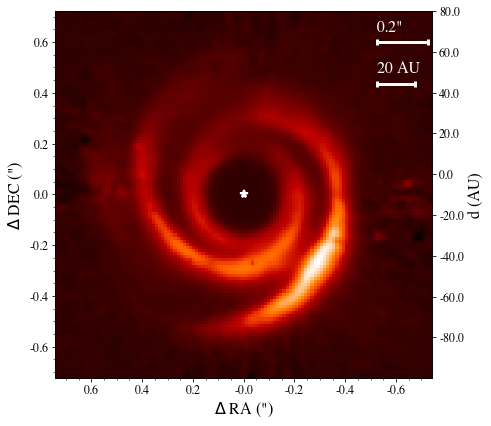

60.0


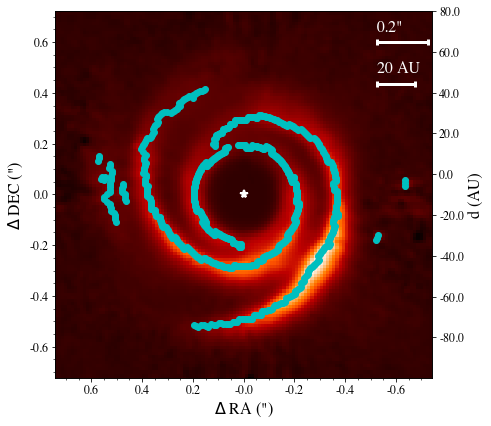

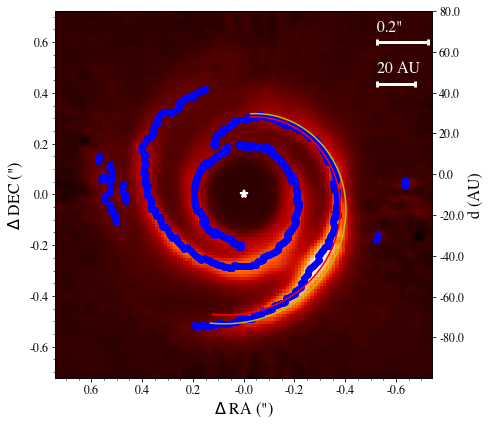

First angle of the spiral:  355.0
Fits file successfully overwritten
spiral trace pitch angle (1st half):  6.599336647262639
spiral trace pitch angle (2nd half):  12.871839560695499
spiral trace pitch angle (global):  10.089219163427565
Fits file successfully overwritten
Mean pitch angle (from all consecutive pairs) muto12_2params_hc_beta: 9.07534250727852deg 

Median pitch angle  (from all consecutive pairs) muto12_2params_hc_beta: 7.660357357061662deg
 
Stddev pitch angle  (from all consecutive pairs) muto12_2params_hc_beta: 10.69878988035256deg
 
Fits file successfully overwritten


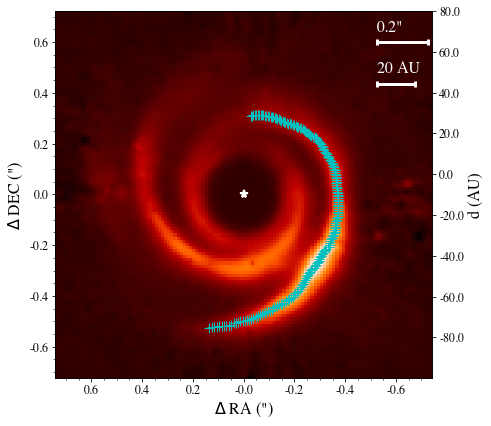

Fits file successfully overwritten
errors on radial separation of trace (max between half kernel and gauss unc): [0.79526917 0.79526917 0.79526917 0.79526917 0.79526917 0.79526917
 0.79526917 0.79526917 0.79526917 0.79526917 0.79526917 0.79526917
 0.79526917 0.79526917 0.79526917 0.79526917 0.79526917 0.79526917
 0.79526917 0.79526917 0.79526917 0.79526917 0.79526917 0.79526917
 0.79526917 0.79526917 0.79526917 0.79526917 0.79526917 0.79526917
 0.79526917 0.79526917 0.79526917 0.79526917 0.79526917 0.79526917
 0.79526917 0.79526917 0.79526917 0.79526917 0.79526917 0.79526917
 0.79526917 0.79526917 0.79526917 0.79526917 0.79526917 0.79526917
 0.79526917 0.79526917 0.79526917 0.79526917 0.79526917 0.79526917
 0.79526917 0.79526917 0.79526917 0.79526917 0.79526917 0.79526917
 0.79526917 0.79526917 0.79526917 0.79526917 0.79526917 0.79526917
 0.79526917 0.79526917 0.79526917 0.79526917 0.79526917 0.79526917
 0.79526917 0.79526917 0.79526917 0.79526917 0.79526917 0.79526917
 0.79526917 0.79

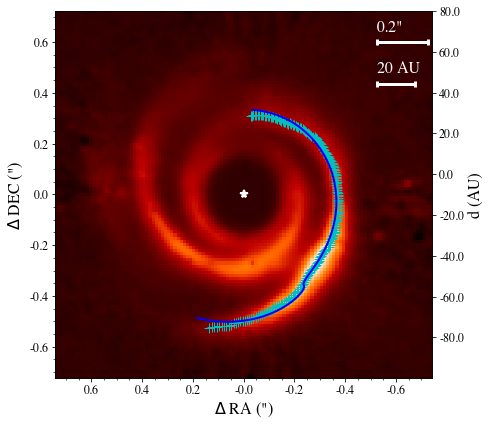

Fits file successfully overwritten


In [45]:
# actual tracing and fitting
fit_res = fit_one_spiral_arm(final_img, polar_coords, 
                                                                              fwhm_ird,
                                                                              clockwise, tot_range_spi, th_spi, 
                                                                              spiral_in_params, 
                      spiral_out_params=(A_out,B_out), sep_ang=sep_ang, bad_angs=bad_angs, ori_img=true_ori_img_tmp,
                                                                              #true_ori_img_ird, 
                      rmin_trace=rmin_trace, rmax_trace=rmax_trace, thresh=thresh, bin_fact=bin_fact, 
                      r_square=r_square, ang_offset=ang_offset,iterate_eq_params=iterate_eq_params, fit_eq=fit_eq, 
                      param_estimate=param_estimate, npt_model=npt_model, 
                      weight_type=weight_type, symmetric_plot=symmetric_plot, log_plot=log_plot,
                      plot_fig=plot_fig, cbar_label=cbar_label, y_ax_lab=y_ax_lab,x_ax_lab=x_ax_lab,
                      pix_to_dist_factor=pix_to_dist_factor_ird,label=fit_eq,search_mode = 'minimize',#search_mode, 
                                                                                 dist=dist,
                      outpath = outpath_tmp,find_uncertainty=find_uncertainty,label_fig=label_fig,
                      font_sz=16,scale_as=scale_as,scale_au=scale_au,color_trace='c+',color_trace2='r+', 
                                                                              ratio_trace=ratio_trace, 
                                                                              ratio_fit=ratio_fit,
                                                                              txt_file=txt_file,
                      #vmin=vmin, vmax=vmax, 
                                                                              deproj=deproj, alpha=alpha, beta=beta,
                                                                              r_c=r_c, th_c=th_c, h_c=h_c,
                                                                             solver=solver,
                                                                             solver_options=solver_options,
                                                                             bounds=bounds)

best_params_img1, trace_img1, model_img1, model_img1_pol = fit_res

### 5.1.2. Higher sampling around kink

We notice an imperfect fit of the points by this model. This may be expected considering that the shape predicted from linear spiral density wave theory is 1) only valid for low-mass planets (in the weakly non-linear regime, the opening angle is expected to be larger due to shocks); (2) most accurate in the vicinity of the planet (i.e. near the kink/twist). Let's try with a higher sampling of points around the kink to give these points more weight.

In [46]:
# define bad angs for better sampling of kink
ndrop = 5 # i.e 1 out of ndrop points will be kept
#bad_angs = [[(i*ndrop)*pi/180,((i+1)*ndrop-1)*pi/180] for i in range(int(360/ndrop)) if (i*ndrop*pi/180 < 0.935*(th_spi_deg*pi/180-th_c) or i*ndrop*pi/180 > 1.09*(th_spi_deg*pi/180-th_c))]
bad_angs = [[(i*ndrop)*pi/180,((i+1)*ndrop-1)*pi/180] for i in range(int(360/ndrop)) if (i*ndrop*pi/180 < 0.96*(th_spi_deg*pi/180-th_c) or i*ndrop*pi/180 > 1.06*(th_spi_deg*pi/180-th_c))]
bad_angs[0][0]=0

In [47]:
# redefine label to avoid overwriting
label_s = 'S1b_IRD'
if deproj:
    label_s+='_deproj'
if r2:
    label_s+='_r2'

In [48]:
outpath_tmp = outpath+'{}/'.format(label_s)
txt_file = outpath+'{}/'.format(label_s)+"Results.txt"

if not isdir(outpath_tmp):
    os.system("mkdir "+outpath_tmp)

In [49]:
ratio_trace=None               # Plot the spiral TRACE for how much of the ACTUAL spiral trace (None=all)
ratio_fit = [0.16,0.8]        # Plot the spiral model fit for how much of the ACTUAL spiral trace (1= radial or azimuthal "length" of spiral trace - depends on whether equation is r(theta) or theta(r))

Let's also try another solver:

In [50]:
from scipy.optimize import Bounds
if 'muto12_2params' in fit_eq:
    solver='Powell'
    solver_options={'xtol':1e-8, 'maxiter':4000, 'ftol':1e-8}#, 'maxfev':8000}
    if 'hc_beta' in fit_eq:
        lb = np.array([0.1*h_c, 0.])
        ub = np.array([10*h_c, 0.45])
        bounds = Bounds(lb,ub)    
    else:
        lb = np.array([0.98*th_c, 0.98*r_c])
        ub = np.array([1.02*th_c, 1.02*r_c])
        bounds = Bounds(lb,ub)    

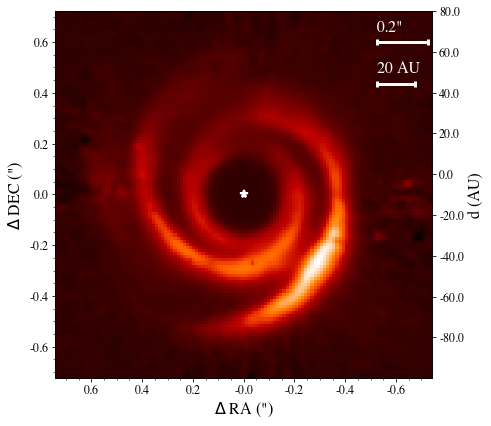

60.0


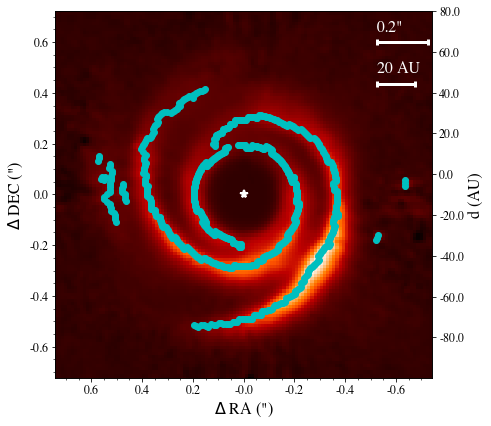

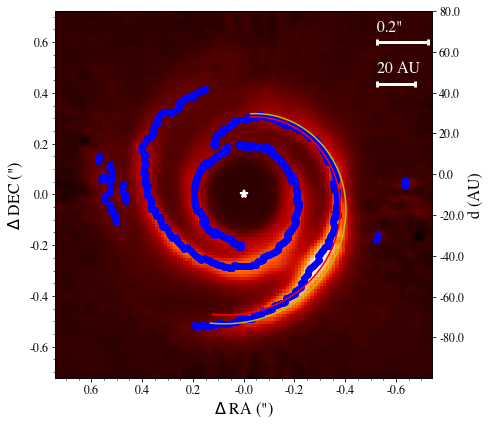

First angle of the spiral:  355.0
Fits file successfully overwritten
spiral trace pitch angle (1st half):  5.95673334941574
spiral trace pitch angle (2nd half):  16.881180282963793
spiral trace pitch angle (global):  9.446358784363843
Fits file successfully overwritten
Mean pitch angle (from all consecutive pairs) muto12_2params_hc_beta: 11.833131307024534deg 

Median pitch angle  (from all consecutive pairs) muto12_2params_hc_beta: 10.443079259850307deg
 
Stddev pitch angle  (from all consecutive pairs) muto12_2params_hc_beta: 9.379549882109433deg
 
Fits file successfully overwritten


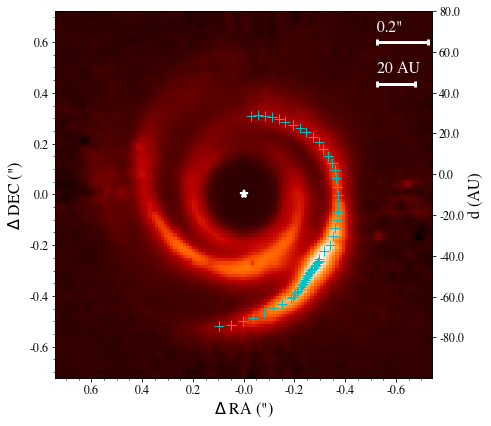

Fits file successfully overwritten
errors on radial separation of trace (max between half kernel and gauss unc): [0.79526917 0.79526917 0.79526917 0.79526917 0.79526917 0.79526917
 0.79526917 0.79526917 0.79526917 0.79526917 0.79526917 0.79526917
 0.79526917 0.79526917 0.79526917 0.79526917 0.79526917 0.79526917
 0.79526917 0.79526917 0.79526917 0.79526917 0.79526917 0.79526917
 0.79526917 0.79526917 0.79526917 0.79526917 0.79526917 0.79526917
 0.79526917 0.79526917 0.79526917 0.79526917 0.79526917 0.79526917
 0.79526917 0.79526917 0.79526917 0.79526917 0.79526917 0.79526917
 0.79526917 0.79526917 0.79526917 0.79526917 0.79526917 0.79526917
 0.79526917 0.79526917 0.79526917 0.79526917 0.79526917 0.79526917
 0.79526917 0.79526917 0.79526917 0.79526917]
Fits file successfully overwritten
Computing the best fit parameters for each spiral...

Powell minimization is running...
Success: True, nit: 2, nfev: 174, chi2r: 175.54896211419492
message: Optimization terminated successfully.
[0.01293

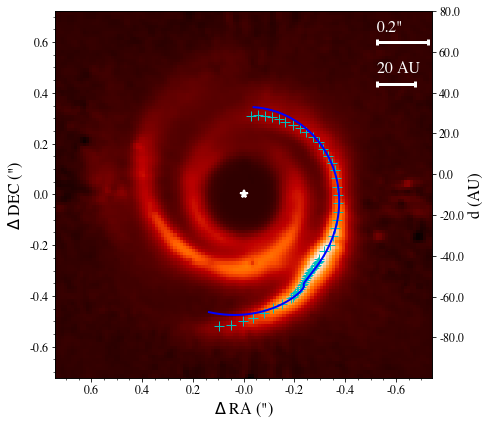

Fits file successfully overwritten


In [51]:
# actual tracing and fitting
fit_res = fit_one_spiral_arm(final_img, polar_coords, fwhm_ird, clockwise, tot_range_spi, th_spi, spiral_in_params, 
                             spiral_out_params=(A_out,B_out), sep_ang=sep_ang, bad_angs=bad_angs, 
                             ori_img=true_ori_img_tmp, rmin_trace=rmin_trace, rmax_trace=rmax_trace, thresh=thresh, 
                             bin_fact=bin_fact, r_square=r_square, ang_offset=ang_offset,
                             iterate_eq_params=iterate_eq_params, fit_eq=fit_eq, param_estimate=param_estimate, 
                             npt_model=npt_model, weight_type=weight_type, symmetric_plot=symmetric_plot, 
                             log_plot=log_plot, plot_fig=plot_fig, cbar_label=cbar_label, y_ax_lab=y_ax_lab,
                             x_ax_lab=x_ax_lab, pix_to_dist_factor=pix_to_dist_factor_ird,label=fit_eq,
                             search_mode = 'minimize', dist=dist, outpath = outpath_tmp,
                             find_uncertainty=find_uncertainty, label_fig=label_fig, font_sz=16, scale_as=scale_as,
                             scale_au=scale_au,color_trace='c+',color_trace2='r+', ratio_trace=ratio_trace, 
                             ratio_fit=ratio_fit, txt_file=txt_file, deproj=deproj, alpha=alpha, beta=beta,
                             r_c=r_c, th_c=th_c, h_c=h_c, solver=solver, solver_options=solver_options, bounds=bounds)
best_params_img1b, trace_imgb, model_img1b, model_img1b_pol = fit_res

Again, it appears difficult to obtain a good fit of the whole spiral, but at least the vicinity of the kink is relatively well reproduced.

## 4.2. S2

### 4.2.1. General Archimedean spiral

Let's try the same for S2, except that this time we fit the trace with a general Archimedean spiral since there is no visual kink in the trace.

In [52]:
deproj = True
r2 = True
filtered = False

In [53]:
tmp_filt = open_fits(outpath+IRDIS_imgname+"_crop.fits")
if filtered:
    # Filter input image for easier identification of local radial maxima
    tmp_filt = frame_filter_lowpass(tmp, fwhm_size=fwhm_ird/2)

Fits HDU-0 data successfully loaded. Data shape: (121, 121)


In [54]:
if deproj:
    if r2:
        ori_img = r2_deproj_img.copy()
        true_ori_img_tmp = r2_deproj_img.copy()
    else:
        ori_img = deproj_img.copy()
        true_ori_img_tmp = deproj_img.copy()   
else:
    if r2:
        ori_img = r2_img.copy()
        true_ori_img_tmp = r2_img.copy()
    else:
        ori_img = tmp_filt.copy()
        true_ori_img_tmp = tmp_filt.copy()

In [55]:
# use "warp" to convert image to polar

# ori_img
## first normalize before using warp:
max_img = np.amax(ori_img)
min_img = np.amin(ori_img)
tmp = ori_img-min_img
tmp = 2*tmp/(max_img-min_img)
tmp = tmp-1
print(np.amin(tmp))
print(np.amax(tmp))

## infer dimensions after warping
nr = int(tmp.shape[1]*np.sqrt(2)/2. + 1)
ntheta = 360

## warp
final_img = warp(tmp, polar2cart_warp, map_args={'center':frame_center(tmp)},output_shape=(nr,ntheta))
final_img = np.roll(final_img, -90, axis=1)

std1 = np.std(final_img)
med1 = np.median(final_img)
print(std1)
print("Median of the whole image: ", med1)

-1.0
1.0
0.34481186
Median of the whole image:  -0.5051341


In [56]:
polar_coords = (np.arange(final_img.shape[0]),np.arange(final_img.shape[1])) # in this case the step is 1 pix and 1 deg along r and theta, making this definition trivial
print("number of radial steps in polar img: ",polar_coords[0].shape[0])
pi=np.pi

number of radial steps in polar img:  86


In [57]:
label_fig='c)'
label_s = 'S2_IRD'
if deproj:
    label_s+='_deproj'
if r2:
    label_s+='_r2' 
    
outpath_tmp = outpath+'{}/'.format(label_s)

if not isdir(outpath_tmp):
    os.system("mkdir "+outpath_tmp)

In [58]:
# PARAMETERS FOR SPIRAL TRACING AND FITTING - to be adapted for each spiral!

## Spiral parameters
tot_range_spi = 210            # total angle range subtended by the spiral in deg (max. allowed: 360)
th_spi_deg = 255                   # rough PA of the root of the spiral
A_in = 0.22                      # in arcsec     - Inner spiral guide parameter A of equation r = A*exp(sign*B*theta)
B_in = 0.24                    # in arcsec/rad - Inner spiral guide parameter B of equation r = A*exp(sign*B*theta)
A_out = 0.22                    # in arcsec     - Outer spiral guide parameter A of equation r = A*exp(sign*B*theta)
B_out = 0.2                   # in arcsec/rad - Outer spiral guide parameter B of equation r = A*exp(sign*B*theta)
sep_ang = 180                  # PA where the outer spiral guide fits better the spiral trace than the inner spiral

rmin_trace = 0.15               # in arcsec - a bit less than radius of the root of the spiral (the algo starts to report local radial max starting at this radius)
rmax_trace = 0.8               # in arcsec - max radius to report local maxima. If None, it is set automatically to max size of the frame.
bin_fact=1                     # radial bin factor, leave it to one to consider each original cell separately
r_square= None                 # whether to scale by r^2. Choice between {'multiply',None,'divide'}

bad_angs = []        #e.g. [[0.89*pi,0.91*pi]] # Set this to a list of pairs of min and max angle values where the inferred trace should not be considered (e.g. spirals broken by shadows). Set to empty list if all points should be considered.

## Tracing options
iterate_eq_params = False      # Whether to stop the code after plotting the test spiral models. If not satisfied with params. Allows to stop earlier and re-run.
thresh = med1                  # Min threshold to consider a local maximum as potential spiral trace. med1 = median of the whole image.

## Spiral fitting
fit_eq = 'gen_archi' # Spiral equation for the fit, choice between {'gen_archi', 'log', 'lin_archi', 'muto12','poly'}, and below, corresponding parameter estimate
param_estimate = np.array([1,1,1]) #np.array([th_c, r_c]) #first guess of parameters for simplex search (usually values do not matter - simplex finds its way, but number of params matter). For muto12: theta in rad from spi root, r in px.
npt_model = None               # Number of points in best-fit spiral model. If not provided, it will automatically pick 5x the number of azimuthal sections of the input simulation (i.e. typically 5*360=1800)
symmetric_plot = False         # Whether to plot the point-symmetric best-fit spiral 
find_uncertainty=False          # whether to compute uncertainties on best-fit params (a bit slower to set to True)
ratio_trace=None               # plot the spiral model for how much of the whole spiral trace (1=same length as spiral trace)
ratio_fit= [0,1]
frac_rr_muto=[1,2]
delta_theta_fit = [0,60]

## Plot options
vmin = np.percentile(ori_img,5) # lower cut for image
vmax = np.percentile(ori_img,99) # upper cut for image
plot_fig = {1,2,3,4,5}         # Index of the figures to be plotted:
# 1 -> just the density map;
# 2 -> 1 + all local radial max;
# 3 -> 2 + inner/outer spiral models to isolate the good spiral traces
# 4 -> isolated trace of the spiral(s)
# 5 -> 4 + best fit to the selected equation

In [59]:
# Formatting - do not modify
tot_range_spi = tot_range_spi*np.pi/180
th_spi = th_spi_deg*np.pi/180
sep_ang = sep_ang*np.pi/180
A_in = int(A_in/plsc_ird)
A_out = int(A_out/plsc_ird) 
spiral_in_params = (A_in, B_in)
spiral_out_params = (A_out, B_out)
rmin_trace = int(rmin_trace/plsc_ird)
rmax_trace = int(rmax_trace/plsc_ird)
ang_offset = 90                # offset between trigonometric and PA angle
weight_type = 'gauss_fit'     # Definition of error bars (weight of each point for the fit), choice between {'more_weight_in', 'uniform', 'individual', 'gaus_fit'}
pix_to_dist_factor_ird = plsc_ird*dist  # pixel scale in au/px (arcsec/px and au/arcsec)

In [60]:
solver='Nelder-Mead'
bounds=None
solver_options={'xtol':1e-2, 'maxiter':4000, 'maxfev':8000}

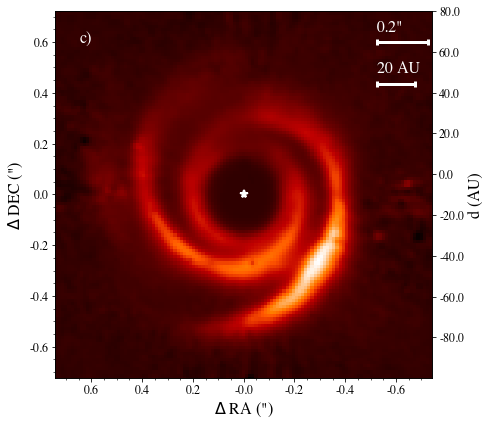

60.0


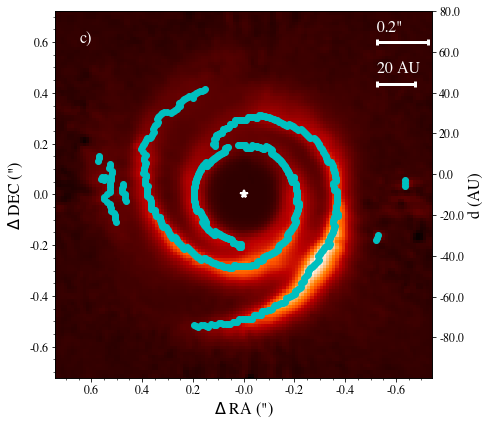

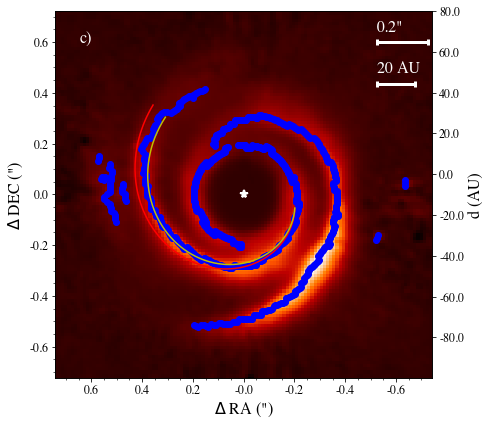

First angle of the spiral:  255.00000000000003
Fits file successfully overwritten
spiral trace pitch angle (1st half):  9.573551010388583
spiral trace pitch angle (2nd half):  12.382829198154024
spiral trace pitch angle (global):  11.205552651803977
Fits file successfully overwritten
Mean pitch angle (from all consecutive pairs) gen_archi: 10.63642084173971deg 

Median pitch angle  (from all consecutive pairs) gen_archi: 10.333127176159824deg
 
Stddev pitch angle  (from all consecutive pairs) gen_archi: 11.04885992984545deg
 
Fits file successfully overwritten


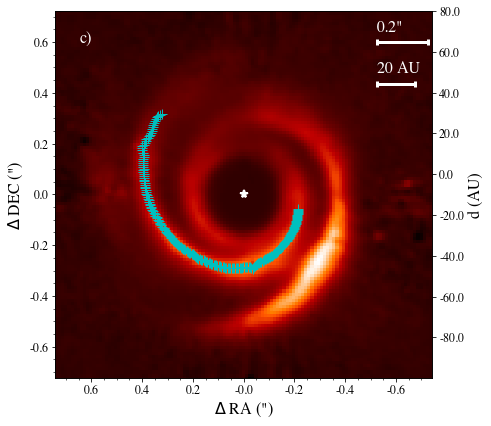

Fits file successfully overwritten
errors on radial separation of trace (max between half kernel and gauss unc): [0.79526917 0.79526917 0.79526917 0.79526917 0.79526917 0.79526917
 0.79526917 0.79526917 0.79526917 0.79526917 0.79526917 0.79526917
 0.79526917 0.79526917 0.79526917 0.79526917 0.79526917 0.79526917
 0.79526917 0.79526917 0.79526917 0.79526917 0.79526917 0.79526917
 0.79526917 0.79526917 0.79526917 0.79526917 0.79526917 0.79526917
 0.79526917 0.79526917 0.79526917 0.79526917 0.79526917 0.79526917
 0.79526917 0.79526917 0.79526917 0.79526917 0.79526917 0.79526917
 0.79526917 0.79526917 0.79526917 0.79526917 0.79526917 0.79526917
 0.79526917 0.79526917 0.79526917 0.79526917 0.79526917 0.79526917
 0.79526917 0.79526917 0.79526917 0.79526917 0.79526917 0.79526917
 0.79526917 0.79526917 0.79526917 0.79526917 0.79526917 0.79526917
 0.79526917 0.79526917 0.97131424 0.79526917 0.79526917 0.79526917
 0.79526917 0.79526917 0.79526917 0.79526917 0.79526917 0.79526917
 0.79526917 0.79

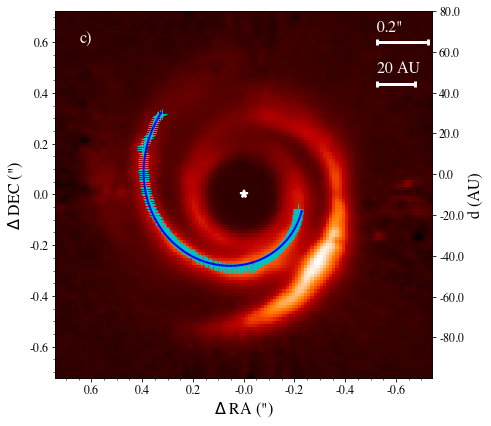

Fits file successfully overwritten


In [61]:
# actual tracing and fitting
fit_res = fit_one_spiral_arm(final_img, polar_coords, fwhm_ird, clockwise, tot_range_spi, th_spi, spiral_in_params, 
                             spiral_out_params=(A_out,B_out), sep_ang=sep_ang, bad_angs=bad_angs, 
                             ori_img=true_ori_img_tmp, rmin_trace=rmin_trace, rmax_trace=rmax_trace, thresh=thresh, 
                             bin_fact=bin_fact, r_square=r_square, ang_offset=ang_offset,
                             iterate_eq_params=iterate_eq_params, fit_eq=fit_eq, param_estimate=param_estimate, 
                             npt_model=npt_model, weight_type=weight_type, symmetric_plot=symmetric_plot, 
                             log_plot=log_plot, plot_fig=plot_fig, cbar_label=cbar_label, y_ax_lab=y_ax_lab,
                             x_ax_lab=x_ax_lab, pix_to_dist_factor=pix_to_dist_factor_ird,label=fit_eq,
                             search_mode = 'minimize', dist=dist, outpath = outpath_tmp,
                             find_uncertainty=find_uncertainty, label_fig=label_fig, font_sz=16, scale_as=scale_as,
                             scale_au=scale_au,color_trace='c+',color_trace2='r+', ratio_trace=ratio_trace, 
                             ratio_fit=ratio_fit, txt_file=txt_file, deproj=deproj, alpha=alpha, beta=beta,
                             r_c=r_c, th_c=th_c, h_c=h_c, solver=solver, solver_options=solver_options, bounds=bounds)
best_params_img2, trace_img2, model_img2, model_img2_pol = fit_res

The fit is satisfactory. This model can be useful for plotting on other images of the system. Note however, that the best way to measure the pitch angle of a spiral is to fit it to a logarithmic spiral: r = a exp(b theta). By definition, the pitch angle of a log spiral is constant and given by ${\rm arctan}(1/b)$.

### 4.2.2. Log spiral

Everything can be kept identical but the labels and equation name.

In [62]:
label_fig='d)'
label_s = 'S2_IRD_log'
if deproj:
    label_s+='_deproj'
if r2:
    label_s+='_r2' 
    
outpath_tmp = outpath+'{}/'.format(label_s)

if not isdir(outpath_tmp):
    os.system("mkdir "+outpath_tmp)

In [63]:
# PARAMETERS FOR SPIRAL TRACING AND FITTING - to be adapted for each spiral!

## Spiral fitting
fit_eq = 'log' # Spiral equation for the fit, choice between {'gen_archi', 'log', 'lin_archi', 'muto12','poly'}, and below, corresponding parameter estimate
param_estimate = np.array([1,1]) #np.array([th_c, r_c]) #first guess of parameters for simplex search (usually values do not matter - simplex finds its way, but number of params matter). For muto12: theta in rad from spi root, r in px.

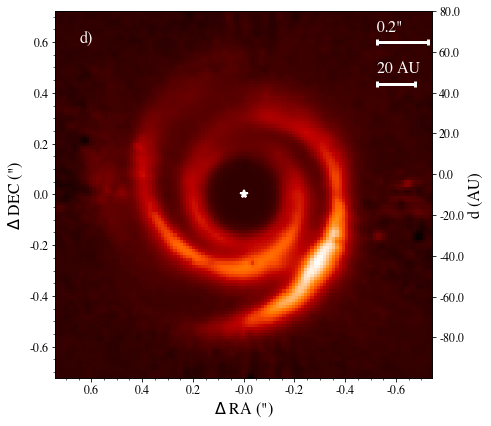

60.0


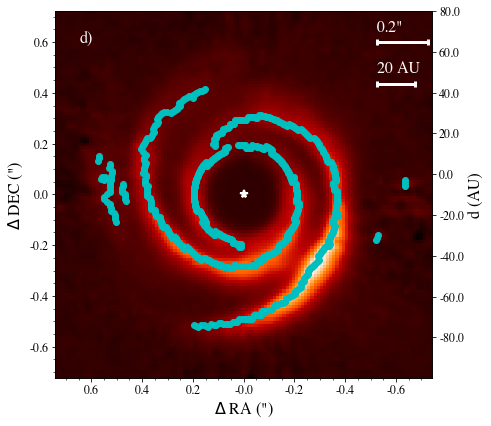

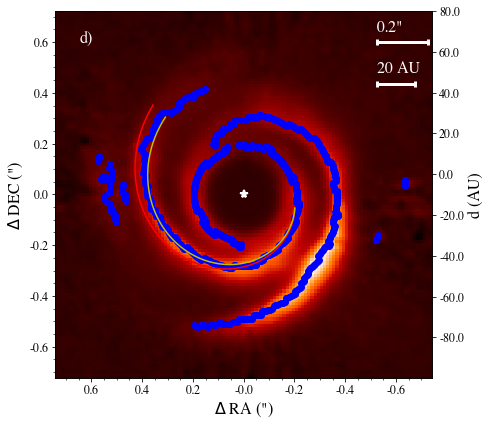

First angle of the spiral:  255.00000000000003
Fits file successfully overwritten
spiral trace pitch angle (1st half):  9.573551010388583
spiral trace pitch angle (2nd half):  12.382829198154024
spiral trace pitch angle (global):  11.205552651803977
Fits file successfully overwritten
Mean pitch angle (from all consecutive pairs) log: 10.63642084173971deg 

Median pitch angle  (from all consecutive pairs) log: 10.333127176159824deg
 
Stddev pitch angle  (from all consecutive pairs) log: 11.04885992984545deg
 
Fits file successfully overwritten


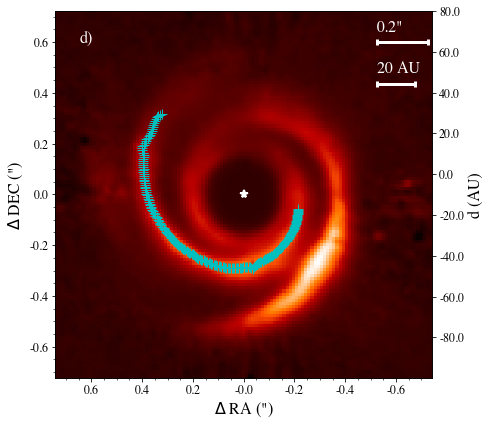

Fits file successfully overwritten
errors on radial separation of trace (max between half kernel and gauss unc): [0.79526917 0.79526917 0.79526917 0.79526917 0.79526917 0.79526917
 0.79526917 0.79526917 0.79526917 0.79526917 0.79526917 0.79526917
 0.79526917 0.79526917 0.79526917 0.79526917 0.79526917 0.79526917
 0.79526917 0.79526917 0.79526917 0.79526917 0.79526917 0.79526917
 0.79526917 0.79526917 0.79526917 0.79526917 0.79526917 0.79526917
 0.79526917 0.79526917 0.79526917 0.79526917 0.79526917 0.79526917
 0.79526917 0.79526917 0.79526917 0.79526917 0.79526917 0.79526917
 0.79526917 0.79526917 0.79526917 0.79526917 0.79526917 0.79526917
 0.79526917 0.79526917 0.79526917 0.79526917 0.79526917 0.79526917
 0.79526917 0.79526917 0.79526917 0.79526917 0.79526917 0.79526917
 0.79526917 0.79526917 0.79526917 0.79526917 0.79526917 0.79526917
 0.79526917 0.79526917 0.97131424 0.79526917 0.79526917 0.79526917
 0.79526917 0.79526917 0.79526917 0.79526917 0.79526917 0.79526917
 0.79526917 0.79

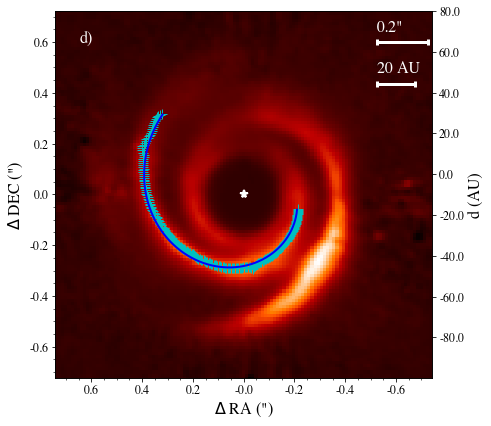

Fits file successfully overwritten


In [64]:
# actual tracing and fitting
fit_res = fit_one_spiral_arm(final_img, polar_coords, fwhm_ird, clockwise, tot_range_spi, th_spi, spiral_in_params, 
                             spiral_out_params=(A_out,B_out), sep_ang=sep_ang, bad_angs=bad_angs, 
                             ori_img=true_ori_img_tmp, rmin_trace=rmin_trace, rmax_trace=rmax_trace, thresh=thresh, 
                             bin_fact=bin_fact, r_square=r_square, ang_offset=ang_offset,
                             iterate_eq_params=iterate_eq_params, fit_eq=fit_eq, param_estimate=param_estimate, 
                             npt_model=npt_model, weight_type=weight_type, symmetric_plot=symmetric_plot, 
                             log_plot=log_plot, plot_fig=plot_fig, cbar_label=cbar_label, y_ax_lab=y_ax_lab,
                             x_ax_lab=x_ax_lab, pix_to_dist_factor=pix_to_dist_factor_ird,label=fit_eq,
                             search_mode = 'minimize', dist=dist, outpath = outpath_tmp,
                             find_uncertainty=find_uncertainty, label_fig=label_fig, font_sz=16, scale_as=scale_as,
                             scale_au=scale_au,color_trace='c+',color_trace2='r+', ratio_trace=ratio_trace, 
                             ratio_fit=ratio_fit, txt_file=txt_file, deproj=deproj, alpha=alpha, beta=beta,
                             r_c=r_c, th_c=th_c, h_c=h_c, solver=solver, solver_options=solver_options, bounds=bounds)
best_params_img2b, trace_img2b, model_img2b, model_img2b_pol = fit_res

The fit to is still relatively satisfactory. Regardless of whether the fit is to a log spiral or not, the routine will attempt to estimate the pitch angle of the spiral trace. Among the printed information, one can see that:
 - the pitch angle of the first half of the trace of S2 is ~9.6deg;
 - the pitch angle of the second half of the trace of S2 is ~12.4deg (i.e. the opening angle appears to slightly increase with radius);
 - the pitch angle of the whole trace of S2 is ~11.2deg;
 - the mean pitch angle from all consecutive pair of points in the trace is ~10.6deg
 - the pitch angle of the best-fit log spiral is ~11.2deg.

## [Go to the top](#Table-of-contents)

# 5. Plot all fits

In [65]:
#FINAL IRDIS MODELS
label_spi_ird = ['S1_IRD_deproj_r2','S2_IRD_deproj_r2']
fit_eq_ird = ['muto12_2params_hc_beta','gen_archi']

In [66]:
# Definition of a plotting routine
def plot_dens(n, ori_img, title_lab='Deprojected image',format_paper=True, log_plot=False, 
              font_sz=12, label='a)', x_ax_lab=r'$\Delta$ RA', y_ax_lab=r'$\Delta$ DEC',
              scale_as=0.1, scale_au=40, vmin=None, vmax=None, deproj=True, cmap='gist_heat',
              plsc=0.01, pix_to_dist_factor=1, col_lab='w'):

    #col = int(n/3)+1
    #row = int(n%3)
    #print("col: ", col
    #print("row: ", row

    if ori_img is None:
        zi = Rho_init
        full_size = Rho_init.shape[0]
    else:
        zi = ori_img
        full_size = ori_img.shape[-1]
    if log_plot:
        zi = np.log10(zi)

    # IMSHOW (like rest of figures from Maddalena)
    #idx_plot = int('1'+str(col)+str(row))
    ax1 = fig.add_subplot(111)
    ax1.set_xlabel(x_ax_lab+' (")',fontsize=font_sz)
    ax1.set_ylabel(y_ax_lab+' (")',fontsize=font_sz)

    if size*plsc > 5:
        delta_tick = 2.
    elif size*plsc > 2:
        delta_tick = 1.
    elif size*plsc > 1.2:
        delta_tick = 0.5
    elif size*plsc > 1.:
        delta_tick = 0.4
    elif size*plsc > 0.6:
        delta_tick = 0.2
    else:
        delta_tick = 0.1

    nticks = int(2*np.floor((size*plsc)/delta_tick)+1)

    xticks = [size+(i*delta_tick/plsc) for i in np.linspace(-int((nticks-1)/2),int((nticks-1)/2),nticks)]    
    xticks_lab = ["{:.1f}".format((x-size)*plsc) for x in xticks]
    if "RA" in x_ax_lab:
        xticks_lab = ["{:.1f}".format(-(x-size)*plsc) for x in xticks]
    yticks = [size+(i*delta_tick/plsc) for i in np.linspace(-int((nticks-1)/2),int((nticks-1)/2),nticks)] 
    yticks_lab = ["{:.1f}".format((y-size)*plsc) for y in yticks]
    #ax1.set_ylim(-size*plsc,size*plsc)
    #ax1.set_xlim(-size*plsc,size*plsc)
    #ax1.set_adjustable('box-forced')
    #ax1.autoscale(enable=True, axis='Y', tight=True)
    #ax1.autoscale(enable=True, axis='X', tight=True)

    ax1.set_xticks(xticks)
    ax1.set_xticklabels(xticks_lab,fontsize=12)
    ax1.set_yticks(yticks)
    ax1.set_yticklabels(yticks_lab,fontsize=12)                                 

    ax1.minorticks_on()
    ax1.plot([size], [size], color=col_lab,lw=3,marker='*',mew=2, ms=8)
    if scale_as is not None:        
        ax1.plot([0.85*full_size,0.85*full_size+(scale_as/plsc)], [0.9*full_size,0.9*full_size], color=col_lab,lw=3, marker="|",markeredgewidth=3)
        ax1.plot([0.85*full_size,0.85*full_size+(scale_au/pix_to_dist_factor)], [0.79*full_size,0.79*full_size], color=col_lab,lw=3, marker="|",markeredgewidth=3)
        ax1.text(0.85*full_size,0.93*full_size, '{:.1f}"'.format(scale_as), color=col_lab,fontsize=font_sz)
        ax1.text(0.85*full_size,0.82*full_size, '{:.0f} AU'.format(scale_au), color=col_lab,fontsize=font_sz)            
    else:
        ax1.plot([0.85*full_size,0.85*full_size+(scale_au/pix_to_dist_factor)], [0.9*full_size,0.9*full_size], color=col_lab,lw=3, marker="|",markeredgewidth=3)
        ax1.text(0.85*full_size,0.93*full_size, '{:.0f} AU'.format(scale_au), color=col_lab,fontsize=font_sz)

    ax1.text(0.06*full_size,0.9*full_size, label, color=col_lab,fontsize=font_sz)
    if not format_paper:
        ax1.set_title(title_lab,fontsize=font_sz)
    if vmin is not None and vmax is not None:
        ax1.imshow(zi, origin='lower',cmap=cmap,interpolation='nearest', vmin=vmin,vmax=vmax)
    else:
        ax1.imshow(zi, origin='lower',cmap=cmap,interpolation='nearest')
    #ax1.set_adjustable('datalim')   

    if deproj:
        if (size*plsc)*dist > 500:
            delta_tick_au = 200
        elif (size*plsc)*dist > 250:
            delta_tick_au = 100
        elif (size*plsc)*dist > 150:
            delta_tick_au = 50
        elif (size*plsc)*dist > 100:
            delta_tick_au = 40
        elif (size*plsc)*dist > 50:
            delta_tick_au = 20
        else:
            delta_tick_au = 10

        nticks_au = int(2*np.floor(size*pix_to_dist_factor/delta_tick_au)+1)            

        #xticks_au = [size+(i*delta_tick_au/pix_to_dist_factor) for i in np.linspace(-int((nticks_au-1)/2),int((nticks_au-1)/2),nticks_au)]    
        #xticks_lab_au = ["{:.1f}".format((x-size)*pix_to_dist_factor) for x in xticks_au]
        yticks_au = [size+(i*delta_tick_au/pix_to_dist_factor) for i in np.linspace(-int((nticks_au-1)/2),int((nticks_au-1)/2),nticks_au)] 
        yticks_lab_au = ["{:.1f}".format((y-size)*pix_to_dist_factor) for y in yticks_au]

        ax2 = ax1.twinx() 
        ax2.set_yticks(yticks_au)
        ax2.set_yticklabels(yticks_lab_au,fontsize=12)                  


        ax2.set_ylabel('d (AU)',fontsize=font_sz)

In [67]:
# read best-fit IRDIS spirals and traces
theta_models_ird = []
rad_models_ird = []
x_models_ird = []
y_models_ird = []
theta_traces_ird = []
rad_traces_ird = []
x_traces_ird = []
y_traces_ird = []
size = (tmp.shape[-1]/2)-0.5

for ll, label_s in enumerate(label_spi_ird):
    outpath_tmp = outpath+'{}/'.format(label_s)
    # MODEL
    thetas, rads = open_fits(outpath_tmp+"Best_fit_{}_PArad_Rarcsec.fits".format(fit_eq_ird[ll])) # thetas' in rad
    theta_models_ird.append(thetas)
    rads /= plsc_ird
    rad_models_ird.append(rads) # r in px
    # convert to cartesian coords
    xspi_m = size+ rads * np.cos(thetas+np.deg2rad(ang_offset))
    yspi_m = size+ rads * np.sin(thetas+np.deg2rad(ang_offset))
    x_models_ird.append(xspi_m)
    y_models_ird.append(yspi_m)
    # TRACE
    rads, thetas = open_fits(outpath_tmp+"Trace_{}_Rarcsec_PAdeg.fits".format(fit_eq_ird[ll])) # thetas' in rad
    theta_traces_ird.append(np.deg2rad(thetas))
    rads /= plsc_ird
    rad_traces_ird.append(rads) # r in px
    # convert to cartesian coords
    xspi_t = size+ rads * np.cos(np.deg2rad(thetas)+np.deg2rad(ang_offset))
    yspi_t = size+ rads * np.sin(np.deg2rad(thetas)+np.deg2rad(ang_offset))
    x_traces_ird.append(xspi_t)
    y_traces_ird.append(yspi_t)

Fits HDU-0 data successfully loaded. Data shape: (2, 1800)
Fits HDU-0 data successfully loaded. Data shape: (2, 190)
Fits HDU-0 data successfully loaded. Data shape: (2, 1800)
Fits HDU-0 data successfully loaded. Data shape: (2, 210)


In [68]:
# plot formatting
color_fit_NIR = 'b'
color_fit_NIR2 = 'm'

In [69]:
dx_fil = 0.276
dy_fil = -0.378
cy, cx = frame_center(tmp)
x_fil = cx + (dx_fil/plsc_ird)
y_fil = cy + (dy_fil/plsc_ird)
print(x_fil,y_fil)

82.51223491027733 29.168026101141926


In [70]:
#true_ori_img_ird = open_fits(outpath+'HD135344B_IRDIS_r2_scaled.fits')
true_ori_img_ird = open_fits(outpath+'HD135344B_IRDIS_r2_scaled_deprojected.fits')

Fits HDU-0 data successfully loaded. Data shape: (121, 121)


In [71]:
rot_ang = 4 #deg (e.g. expected rotation between 2 epochs of observation)

In [72]:
#adapt read best-fit IRDIS spirals and traces
theta_models_ird = []
rad_models_ird = []
x_models_ird = []
y_models_ird = []
theta_traces_ird = []
rad_traces_ird = []
x_traces_ird = []
y_traces_ird = []
size = (true_ori_img_ird.shape[-1]/2)-0.5

for ll, label_s in enumerate(label_spi_ird):
    outpath_tmp = outpath+'{}/'.format(label_s)
    # MODEL
    thetas, rads = open_fits(outpath_tmp+"Best_fit_{}_PArad_Rarcsec.fits".format(fit_eq_ird[ll])) # thetas' in rad
    theta_models_ird.append(thetas)
    rads /= plsc_ird
    rad_models_ird.append(rads) # r in px
    # convert to cartesian coords
    xspi_m = size+ rads * np.cos(thetas+np.deg2rad(ang_offset))
    yspi_m = size+ rads * np.sin(thetas+np.deg2rad(ang_offset))
    x_models_ird.append(xspi_m)
    y_models_ird.append(yspi_m)
    # TRACE
    rads, thetas = open_fits(outpath_tmp+"Trace_{}_Rarcsec_PAdeg.fits".format(fit_eq_ird[ll])) # thetas' in rad
    theta_traces_ird.append(np.deg2rad(thetas))
    rads /= plsc_ird
    rad_traces_ird.append(rads) # r in px
    # convert to cartesian coords
    xspi_t = size+ rads * np.cos(np.deg2rad(thetas)+np.deg2rad(ang_offset))
    yspi_t = size+ rads * np.sin(np.deg2rad(thetas)+np.deg2rad(ang_offset))
    x_traces_ird.append(xspi_t)
    y_traces_ird.append(yspi_t)
    
# rotated S1
ll=0
outpath_tmp = outpath+'{}/'.format(label_spi_ird[ll])
thetas, rads = open_fits(outpath_tmp+"Best_fit_{}_PArad_Rarcsec.fits".format(fit_eq_ird[ll])) # thetas' in rad
#thetas+=np.deg2rad(tot_rot_ird)
rads /= plsc_ird
# convert to cartesian coords
xspi_m = size+ rads * np.cos(thetas+np.deg2rad(ang_offset+rot_ang))
yspi_m = size+ rads * np.sin(thetas+np.deg2rad(ang_offset+rot_ang))
x_models_ird.append(xspi_m)
y_models_ird.append(yspi_m)

Fits HDU-0 data successfully loaded. Data shape: (2, 1800)
Fits HDU-0 data successfully loaded. Data shape: (2, 190)
Fits HDU-0 data successfully loaded. Data shape: (2, 1800)
Fits HDU-0 data successfully loaded. Data shape: (2, 210)
Fits HDU-0 data successfully loaded. Data shape: (2, 1800)


In [73]:
# plot formatting
color_trace_NIR = 'c+'
color_fit_NIR = 'b'
color_fit_NIR2 = 'm'

In [74]:
dx_fil = 0.276
dy_fil = -0.378
cy, cx = frame_center(true_ori_img_ird)
x_fil = cx + (dx_fil/plsc_ird)
y_fil = cy + (dy_fil/plsc_ird)
print(x_fil,y_fil)

82.51223491027733 29.168026101141926


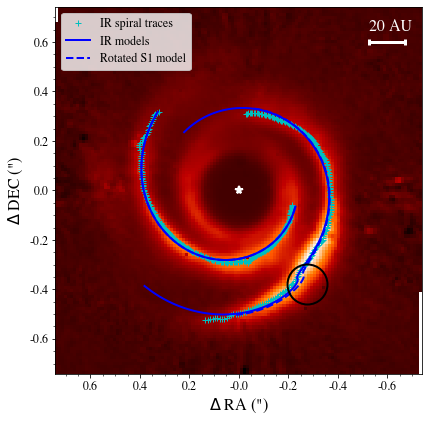

In [75]:
# plot all spiral fits on IRDIS image
fig = plt.figure(4,figsize=(0.9*7.5,0.9*7.5))
plot_dens(4, true_ori_img_ird, 'All spiral models', log_plot=False, #log_plot, 
          font_sz=16, label='', scale_as=None, scale_au=scale_au, #vmin=vmin, vmax=vmax, 
          deproj=False, cmap='gist_heat', pix_to_dist_factor=plsc_ird*dist, plsc=plsc_ird, col_lab='w')

# IR spiral traces
plt.plot(x_traces_ird[0], y_traces_ird[0], color_trace_NIR, linewidth=1, label='IR spiral traces')
plt.plot(x_traces_ird[1], y_traces_ird[1], color_trace_NIR, linewidth=1)

# NIR spirals
#plt.plot(x_m_NIR[0], y_m_NIR[0], color_fit_NIR, linewidth=2, label='IR spirals (M12)')
#plt.plot(x_m_NIR[1], y_m_NIR[1], color_fit_NIR, linewidth=2)
#plt.plot(x_models_ird[0], y_models_ird[0], color_fit_NIR, linewidth=2, label='IR spirals (S16)')
ratio_fit_a = [0.,1]
ratio_fit_b = [0.,0.99]
npts = len(x_models_ird[1])
cut1a = int(npts*ratio_fit_a[0])
cut2a = int(npts*ratio_fit_a[1])
cut1b = int(npts*ratio_fit_b[0])
cut2b = int(npts*ratio_fit_b[1])
plt.plot(x_models_ird[1][cut1a:cut2a], y_models_ird[1][cut1a:cut2a], color_fit_NIR+'--', linewidth=2)#, label='IR S2 model')
plt.plot(x_models_ird[1][cut1b:cut2b], y_models_ird[1][cut1b:cut2b], color_fit_NIR+'-', linewidth=2)#, label='IR S2 model')

# rotated NIR spirals
#plt.plot(x_m_NIR[2], y_m_NIR[2], color_fit_NIR+'--', linewidth=2, label='Rotated S1 model (M12)')
ratio_fit_a = [0.05,1]
ratio_fit_b = [0.11,0.83]
npts = len(x_models_ird[2])
cut1a = int(npts*ratio_fit_a[0])
cut2a = int(npts*ratio_fit_a[1])
cut1b = int(npts*ratio_fit_b[0])
cut2b = int(npts*ratio_fit_b[1])
plt.plot(x_models_ird[0][cut1a:cut2a], y_models_ird[0][cut1a:cut2a], color_fit_NIR+'-', linewidth=2, label='IR models')
plt.plot(x_models_ird[2][cut1b:cut2b], y_models_ird[2][cut1b:cut2b], color_fit_NIR+'--', linewidth=2, label='Rotated S1 model')

# plot a circle at filament
plt.plot(x_fil, y_fil, 'ko',ms=40,mew=2,fillstyle='none')#, label='ALMA continuum filament')

#plt.scatter()
plt.legend()
plt.savefig(outpath_fig+"fig_spiral_models_IR.pdf", dpi=300, bbox_inches='tight')
plt.show()

## [Go to the top](#Table-of-contents)